>self.action_dim = 5

        a = self.sess.run(self.a, {self.S: s[np.newaxis, :]})[0]
        a = np.clip(np.random.normal(a, self.var), -2, 2)
        
        a *= mem_std[self.s_dim: self.s_dim + self.a_dim]
        a += mem_mean[self.s_dim: self.s_dim + self.a_dim]
        
Adjust to:

        a = self.sess.run(self.a, {self.S: s[np.newaxis, :]})[0]
        
        a *= mem_std[self.s_dim: self.s_dim + self.a_dim]
        a += mem_mean[self.s_dim: self.s_dim + self.a_dim]        
        
        a = np.clip(np.random.normal(a, self.var), -2, 2)

In [1]:
"""
View more on the tutorial page: https://morvanzhou.github.io/tutorials/
"""

import tensorflow as tf
import numpy as np
import manipulator

# reproducible
np.random.seed(1)
tf.set_random_seed(1)
#####################  hyper parameters  ####################


MAX_EP_STEPS = 500
LR_A = 0.001    # learning rate for actor
LR_C = 0.002    # learning rate for critic
GAMMA = 0.9     # reward discount
TAU = 0.01      # soft replacement
MEMORY_CAPACITY = 10000
BATCH_SIZE = 32

RENDER = False

###############################  DDPG  ####################################

class DDPG(object):
    def __init__(self, a_dim, s_dim, a_bound,):
        self.memory = np.zeros((MEMORY_CAPACITY, s_dim * 2 + a_dim + 1), dtype=np.float32)
        self.pointer = 0
        self.sess = tf.Session()
        self.var = 3.0
        # self.a_replace_counter, self.c_replace_counter = 0, 0

        self.a_dim, self.s_dim, self.a_bound = a_dim, s_dim, a_bound,
        self.S = tf.placeholder(tf.float32, [None, s_dim], 's')
        self.S_ = tf.placeholder(tf.float32, [None, s_dim], 's_')
        self.R = tf.placeholder(tf.float32, [None, 1], 'r')

        with tf.variable_scope('Actor'):
            self.a = self.build_a_nn(self.S, scope='eval', trainable=True)
            a_ = self.build_a_nn(self.S_, scope='target', trainable=False)
        with tf.variable_scope('Critic'):
            # assign self.a = a in memory when calculating q for td_error,
            # otherwise the self.a is from Actor when updating Actor
            q = self.build_c_nn(self.S, self.a, scope='eval', trainable=True)
            q_ = self.build_c_nn(self.S_, a_, scope='target', trainable=False)

        # networks parameters
        self.ae_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/eval')
        self.at_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/target')
        self.ce_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Critic/eval')
        self.ct_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Critic/target')

        # target net replacement
        self.soft_replace = [[tf.assign(at, (1-TAU)*at+TAU*ae), tf.assign(ct, (1-TAU)*ct+TAU*ce)]
            for at, ae, ct, ce in zip(self.at_params, self.ae_params, self.ct_params, self.ce_params)]

        q_target = self.R + GAMMA * q_
        # in the feed_dic for the td_error, the self.a should change to actions in memory
        td_error = tf.losses.mean_squared_error(labels=(self.R + GAMMA * q_), predictions=q)
        self.ctrain = tf.train.AdamOptimizer(LR_C).minimize(td_error, name="adam-ink", var_list = self.ce_params)

        a_loss = - tf.reduce_mean(q)    # maximize the q
        self.atrain = tf.train.AdamOptimizer(LR_A).minimize(a_loss, var_list=self.ae_params)

        tf.summary.FileWriter("logs/", self.sess.graph)

        self.sess.run(tf.global_variables_initializer())

       

    def choose_action(self, s):
        
        mem_mean = np.array([ 0.48621982, -0.39433715,  0.55701429,  0.71694756,  0.93387568,
        0.37078592, -0.14167269,  0.40072495,  0.25386503,  0.4805119 ,
        0.09596774, -0.11102104,  0.16225703,  0.06218311,  0.19568023,
       -0.26812184,  0.48575708, -0.39573932,  0.55680048,  0.71941608,
        0.93555212,  0.37175739, -0.14246416,  0.40183851,  0.25530386,
        0.48238301], dtype=np.float32)
        
        mem_std = np.array([ 0.77474898,  0.72022182,  0.56043774,  0.90410036,  0.12644294,
        0.24395365,  0.3367165 ,  0.20749338,  0.49386111,  0.27530244,
        0.13662679,  0.10744574,  0.08928268,  0.18348816,  0.02752163,
        0.06287373,  0.77596879,  0.72043914,  0.56105018,  0.90423542,
        0.11954755,  0.24412741,  0.3376236 ,  0.20702067,  0.49511331,
        0.27521592], dtype=np.float32)    
    
    
        s -= mem_mean[:self.s_dim]
        s /= mem_std[:self.s_dim]
        
        a = self.sess.run(self.a, {self.S: s[np.newaxis, :]})[0]
        
        a *= mem_std[self.s_dim: self.s_dim + self.a_dim]
        a += mem_mean[self.s_dim: self.s_dim + self.a_dim]
        
        a = np.clip(np.random.normal(a, self.var), -2, 2)

        return a

    def learn(self):
        # soft target replacement
        self.sess.run(self.soft_replace)

        indices = np.random.choice(MEMORY_CAPACITY, size=BATCH_SIZE)
        bt = self.memory[indices, :]
        bs = bt[:, :self.s_dim]
        ba = bt[:, self.s_dim: self.s_dim + self.a_dim]
        br = bt[:, -self.s_dim - 1: -self.s_dim]
        bs_ = bt[:, -self.s_dim:]

        self.sess.run(self.atrain, {self.S: bs})
        self.sess.run(self.ctrain, {self.S: bs, self.a: ba, self.R: br, self.S_: bs_})

    def store_transition(self, s, a, r, s_):

        trans = np.hstack((s,a,[r],s_))
        
        # batch normalization
        mem_mean = np.array([ 0.48621982, -0.39433715,  0.55701429,  0.71694756,  0.93387568,
        0.37078592, -0.14167269,  0.40072495,  0.25386503,  0.4805119 ,
        0.09596774, -0.11102104,  0.16225703,  0.06218311,  0.19568023,
       -0.26812184,  0.48575708, -0.39573932,  0.55680048,  0.71941608,
        0.93555212,  0.37175739, -0.14246416,  0.40183851,  0.25530386,
        0.48238301], dtype=np.float32)
        
        mem_std = np.array([ 0.77474898,  0.72022182,  0.56043774,  0.90410036,  0.12644294,
        0.24395365,  0.3367165 ,  0.20749338,  0.49386111,  0.27530244,
        0.13662679,  0.10744574,  0.08928268,  0.18348816,  0.02752163,
        0.06287373,  0.77596879,  0.72043914,  0.56105018,  0.90423542,
        0.11954755,  0.24412741,  0.3376236 ,  0.20702067,  0.49511331,
        0.27521592], dtype=np.float32)    
        
        trans -= mem_mean
        trans /= mem_std
        
        
        # print("trans: ", trans)
        index = self.pointer % MEMORY_CAPACITY
        self.memory[index, :] = trans
        self.pointer += 1

        if self.pointer > MEMORY_CAPACITY:
            self.var *= 0.99995
            self.learn()
    def build_a_nn(self, s, scope, trainable):
        # Actor DPG
        with tf.variable_scope(scope):
            l1 = tf.layers.dense(s, 30, activation = tf.nn.tanh, name = 'l1', trainable = trainable)
            a = tf.layers.dense(l1, self.a_dim, activation = tf.nn.tanh, name = 'a', trainable = trainable)     
            return tf.multiply(a, self.a_bound, name = "scaled_a")  
    # def _build_c(self, s, a, scope, trainable):
    #     with tf.variable_scope(scope):
    #         n_l1 = 30
    #         w1_s = tf.get_variable('w1_s', [self.s_dim, n_l1], trainable=trainable)
    #         w1_a = tf.get_variable('w1_a', [self.a_dim, n_l1], trainable=trainable)
    #         b1 = tf.get_variable('b1', [1, n_l1], trainable=trainable)
    #         net = tf.nn.tanh(tf.matmul(s, w1_s) + tf.matmul(a, w1_a) + b1)
    #         return tf.layers.dense(net, 1, trainable=trainable)  # Q(s,a)
    def build_c_nn(self, s, a, scope, trainable):
        # Critic Q-leaning
        with tf.variable_scope(scope):
            n_l1 = 30
            w1_s = tf.get_variable('w1_s', [self.s_dim, n_l1], trainable = trainable)
            w1_a = tf.get_variable('w1_a', [self.a_dim, n_l1], trainable = trainable)
            b1 = tf.get_variable('b1', [1, n_l1], trainable = trainable)
            net = tf.nn.tanh( tf.matmul(s, w1_s) + tf.matmul(a, w1_a) + b1 )

            q = tf.layers.dense(net, 1, trainable = trainable)
            return q

    
###############################  training  ####################################

env = manipulator.manipulator()
# env = env.unwrapped
# env.seed(1)

s_dim = env.state_dim
a_dim = env.action_dim
a_bound = 0.2

ddpg = DDPG(a_dim, s_dim, a_bound)

r_save = []

# var = 3  # control exploration


In [2]:
a_save = []

In [3]:
MAX_EPISODES = 200

In [4]:
for i in range(MAX_EPISODES):
    print("i: ", i)
    s = env.reset()
    ep_reward = 0
    for j in range(MAX_EP_STEPS):
        if RENDER:
            env.render()

        # Add exploration noise
        a = ddpg.choose_action(s)
        # a = np.clip(np.random.normal(a, var), -2, 2)    # add randomness to action selection for exploration
        # print("a: ", a)
        s_, r, done, info = env.step(a)
        # print("r: ", r)
        ddpg.store_transition(s, a, r, s_)

        # if ddpg.pointer > MEMORY_CAPACITY:
        #     ddpg.var *= .9995    # decay the action randomness
        #     ddpg.learn()

        s = s_
        ep_reward += r

        

        if j == MAX_EP_STEPS-1:
            r_save.append(ep_reward)
            print('Episode:', i, ' Reward: %i' % int(ep_reward), 'Explore: %.2f' % ddpg.var, )
            # if ep_reward > -300:RENDER = True
            break


i:  0
Episode: 0  Reward: -175 Explore: 3.00
i:  1
Episode: 1  Reward: -178 Explore: 3.00
i:  2
Episode: 2  Reward: -181 Explore: 3.00
i:  3
Episode: 3  Reward: -179 Explore: 3.00
i:  4
Episode: 4  Reward: -179 Explore: 3.00
i:  5
Episode: 5  Reward: -179 Explore: 3.00
i:  6
Episode: 6  Reward: -177 Explore: 3.00
i:  7
Episode: 7  Reward: -180 Explore: 3.00
i:  8
Episode: 8  Reward: -184 Explore: 3.00
i:  9
Episode: 9  Reward: -178 Explore: 3.00
i:  10
Episode: 10  Reward: -177 Explore: 3.00
i:  11
Episode: 11  Reward: -184 Explore: 3.00
i:  12
Episode: 12  Reward: -178 Explore: 3.00
i:  13
Episode: 13  Reward: -179 Explore: 3.00
i:  14
Episode: 14  Reward: -179 Explore: 3.00
i:  15
Episode: 15  Reward: -183 Explore: 3.00
i:  16
Episode: 16  Reward: -182 Explore: 3.00
i:  17
Episode: 17  Reward: -177 Explore: 3.00
i:  18
Episode: 18  Reward: -181 Explore: 3.00
i:  19
Episode: 19  Reward: -181 Explore: 3.00
i:  20
Episode: 20  Reward: -180 Explore: 2.93
i:  21
Episode: 21  Reward: -181 

Episode: 172  Reward: -120 Explore: 0.07
i:  173
Episode: 173  Reward: -120 Explore: 0.06
i:  174
Episode: 174  Reward: -119 Explore: 0.06
i:  175
Episode: 175  Reward: -119 Explore: 0.06
i:  176
Episode: 176  Reward: -119 Explore: 0.06
i:  177
Episode: 177  Reward: -119 Explore: 0.06
i:  178
Episode: 178  Reward: -120 Explore: 0.06
i:  179
Episode: 179  Reward: -119 Explore: 0.05
i:  180
Episode: 180  Reward: -119 Explore: 0.05
i:  181
Episode: 181  Reward: -119 Explore: 0.05
i:  182
Episode: 182  Reward: -120 Explore: 0.05
i:  183
Episode: 183  Reward: -119 Explore: 0.05
i:  184
Episode: 184  Reward: -119 Explore: 0.05
i:  185
Episode: 185  Reward: -120 Explore: 0.05
i:  186
Episode: 186  Reward: -119 Explore: 0.05
i:  187
Episode: 187  Reward: -119 Explore: 0.04
i:  188
Episode: 188  Reward: -120 Explore: 0.04
i:  189
Episode: 189  Reward: -120 Explore: 0.04
i:  190
Episode: 190  Reward: -120 Explore: 0.04
i:  191
Episode: 191  Reward: -120 Explore: 0.04
i:  192
Episode: 192  Reward

np.save("memory-action_dim5-norm", ddpg.memory)

In [5]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
all_reward = r_save

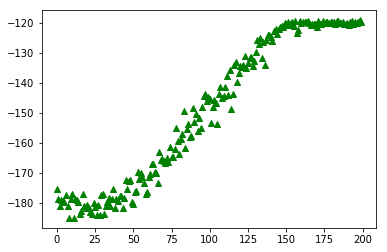

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot([1, 2, 3, 4], [10, 20, 25, 30], color='lightblue', linewidth=3) # plot line
ax.scatter(range(len(all_reward)), all_reward, color='green', marker='^') # plot points
# ax.set_xlim(0.5, 4.5)
plt.show()